In [1]:
%load_ext cythonmagic

/usr/lib/python2.7/site-packages/IPython/extensions/cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


In [2]:
import numpy as np
import h5py as hp
from scipy.constants import m_p, c, e

In [3]:
import sys
sys.path.append("../../../PyHEADTAIL/")

from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.particles.generators import Gaussian6DTwiss
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap

PyHEADTAIL v1.9.1.12




ImportError: cannot import name Gaussian6DTwiss

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from colorsys import hsv_to_rgb

def colorprog(i_prog, Nplots, v1 = .9, v2 = 1.):
        return hsv_to_rgb(float(i_prog)/float(Nplots), v1, v2)

In [23]:
gamma = 27.7

# Basic parameters.
n_turns = 1024
n_segments = 1
n_macroparticles = 1000000
Q_x = 20.13
Q_y = 20.18
Q_s = 0.016875

C = 6911.
R = C / (2.*np.pi)

alpha_x = 0.
alpha_y = 0.
beta_x = 54.64
beta_y = 54.50
alpha_0 = [0.0031]

intensity = 6e10
sigma_z = 0.23
gamma_t = 1. / np.sqrt(alpha_0)
p0 = np.sqrt(gamma**2 - 1) * m_p * c
beta = np.sqrt(1 - gamma**-2)
eta = alpha_0[0] - gamma**-2

beta_z = (eta * C / (2 * np.pi * Q_s))

epsn_x = 2e-6 # [m rad]
epsn_y = 2e-6 # [m rad]
epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)

bunch = Gaussian6DTwiss(
    macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
    gamma_reference=gamma, mass=m_p, circumference=C,
    alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
    alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
    beta_z=beta_z, epsn_z=epsn_z).generate()

In [7]:
def make_concentric_slices(bunch, n_azim_slices, n_rings, n_sigma_radial=2., showPlot=False):

    # Slice radially
    concentric_rings = np.linspace(0., n_sigma_radial*np.sqrt(2)*sigma_z, n_rings+1)
    concentric_rings = concentric_rings[1:]
    rings_width = np.abs(concentric_rings[-1] - concentric_rings[-2])
    
    jlong = np.sqrt(bunch.z*bunch.z + beta_z*beta_z * bunch.dp*bunch.dp)
    ring_index_of_particle = np.int_(jlong / (rings_width))    
    
    mask_ = (ring_index_of_particle >= n_rings)
    ring_index_of_particle[mask_] = -1
    
    # Slice azimuthally
    azim_slices = np.linspace(0., 2.*np.pi, n_azim_slices+1)
    angular_width = np.abs(azim_slices[-1] - azim_slices[-2])

    #atan_dp_over_z = np.arctan(np.abs(beta_z*bunch.dp / bunch.z))
    #for jj in xrange(n_macroparticles):
    #    if bunch.z[jj] < 0 and bunch.dp[jj] > 0:
    #        atan_dp_over_z[jj] = np.pi - atan_dp_over_z[jj]
    #    elif bunch.z[jj] < 0 and bunch.dp[jj] <= 0:
    #        atan_dp_over_z[jj] += np.pi
    #    elif bunch.z[jj] > 0 and bunch.dp[jj] < 0:
    #        atan_dp_over_z[jj] = 2.*np.pi - atan_dp_over_z[jj]
    
    atan_dp_over_z = np.arctan(np.abs(beta_z*bunch.dp / bunch.z))
    # CASE I IS ALREADY FINE (z and dp both > 0)
    # CASE II
    mask_ = ((bunch.z < 0) & (bunch.dp > 0))
    atan_dp_over_z[mask_] = np.pi - atan_dp_over_z[mask_]
    # CASE III
    mask_ = ((bunch.z < 0) & (bunch.dp <= 0))
    atan_dp_over_z[mask_] += np.pi
    # CASE IV
    mask_ = ((bunch.z > 0) & (bunch.dp < 0))
    atan_dp_over_z[mask_] = 2.*np.pi - atan_dp_over_z[mask_]

    azim_slice_index_of_particle = np.int_(atan_dp_over_z / (angular_width))
    
    if showPlot:
        plt.figure(1, figsize=(10,10))
        plt.plot(bunch.z, beta_z*bunch.dp, 'o', mec='None', color='black')
        phi = np.linspace(0, 2*np.pi, 100)
        for i in xrange(n_azim_slices):
            if azim_slices[i] < np.pi/2. or azim_slices[i] >= 3.*np.pi/2.:
                zzz = np.linspace(0., 1., 10)
                ddp = zzz*np.tan(azim_slices[i])
                plt.plot(zzz, ddp, 'grey')
            elif azim_slices[i] >= np.pi/2. and azim_slices[i] < 3*np.pi/2.:
                zzz = np.linspace(0., -1., 10)
                ddp = zzz*np.tan(azim_slices[i])
                plt.plot(zzz, ddp, 'grey')

            for j in xrange(n_rings):
                plt.plot(concentric_rings[j]*np.cos(phi), concentric_rings[j]*np.sin(phi), 'grey')

                # ID particles in specific cell (i,j), i.e. (azim_slice, ring)
                particles_in_cell = np.where(((azim_slice_index_of_particle == i) &
                                              (ring_index_of_particle == j)))[0]
                plt.plot(bunch.z.take(particles_in_cell),
                         beta_z*bunch.dp.take(particles_in_cell),
                         'o', mec='None', #color=colorprog(j, n_rings))
                         color=colorprog(i+j*n_rings, int(n_rings*n_azim_slices*1.6)))
        plt.grid('on')
        plt.xlim(np.amin(bunch.z), np.amax(bunch.z))
        plt.ylim(np.amin(bunch.z), np.amax(bunch.z))

        plt.show()
        
    return azim_slice_index_of_particle, ring_index_of_particle
        
def add_statistics(bunch, n_azim_slices, n_rings, azim_slice_idx, ring_idx):
    for i in xrange(n_azim_slices):
        for j in xrange(n_rings):
            idx_in_cell = np.where(((azim_slice_idx == i) & (ring_idx == j)))[0]
            mean_x_cell[i,j] = np.mean(bunch.x.take(idx_in_cell))
            mean_y_cell[i,j] = np.mean(bunch.y.take(idx_in_cell))
            mean_z_cell[i,j] = np.mean(bunch.z.take(idx_in_cell))
            mean_dp_cell[i,j] = np.mean(bunch.dp.take(idx_in_cell))
            n_particles_cell[i,j] = len(idx_in_cell)       

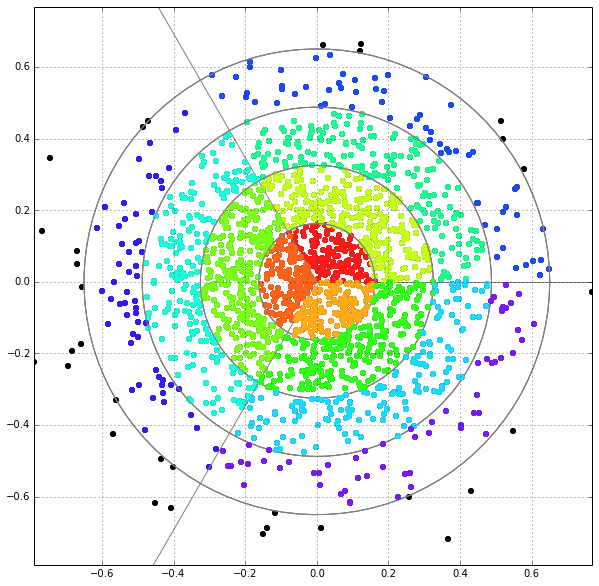

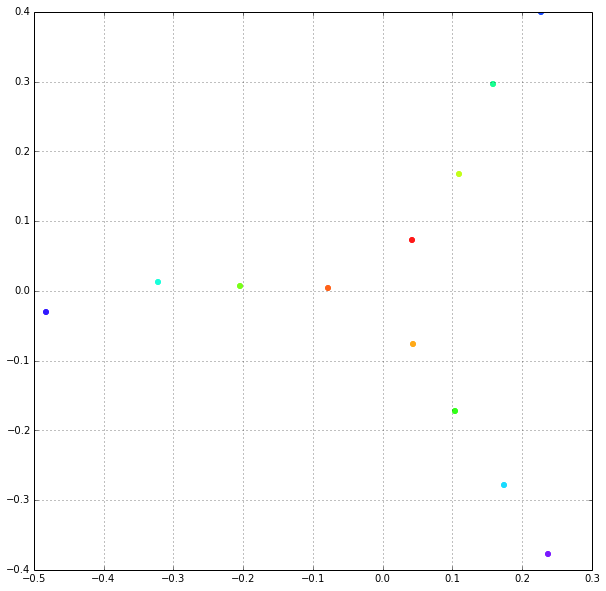

In [8]:
n_azim_slices = 3
n_rings = 4

mean_x_cell = np.zeros((n_azim_slices, n_rings))
mean_y_cell = np.zeros((n_azim_slices, n_rings))
mean_z_cell = np.zeros((n_azim_slices, n_rings))
mean_dp_cell = np.zeros((n_azim_slices, n_rings))
n_particles_cell = np.zeros((n_azim_slices, n_rings))

azim_idx, ring_idx = make_concentric_slices(bunch, n_azim_slices, n_rings, showPlot=True)
add_statistics(bunch, n_azim_slices, n_rings, azim_idx, ring_idx)

plt.figure(2, figsize=(10,10))
for az in xrange(n_azim_slices):
    for ri in xrange(n_rings):
        plt.plot(mean_z_cell[az,ri], beta_z*mean_dp_cell[az,ri], 'o', mec='None',
                 color=colorprog(az+ri*n_rings, int(n_rings*n_azim_slices*1.6)))
plt.grid('on')
plt.show()

In [7]:
%timeit make_concentric_slices(bunch, n_azim_slices, n_rings)

10 loops, best of 3: 76.9 ms per loop


In [8]:
azim_idx, ring_idx = make_concentric_slices(bunch, n_azim_slices, n_rings)
add_statistics(bunch, n_azim_slices, n_rings, azim_idx, ring_idx)

In [9]:
%timeit add_statistics(bunch, n_azim_slices, n_rings, azim_idx, ring_idx)

1 loops, best of 3: 4.64 s per loop


## Cython, stats only

In [20]:
%%cython -lm
cimport cython
from libc.math cimport sin
import numpy as np
cimport numpy as np

# SEEMS TO WORK.
cpdef cy_statistics(bunch, int n_azim_slices, int n_rings,
                    int[::1] azim_slice_idx, int[::1] ring_idx):

    cdef double[::1] x = bunch.x
    cdef double[::1] y = bunch.y
    cdef double[::1] z = bunch.z
    cdef double[::1] dp = bunch.dp
    cdef unsigned int n_particles = x.shape[0]
    
    cdef int[:,::1] n_part_per_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.int32)
    cdef double[:,::1] mean_x_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_y_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_z_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_dp_cell = np.zeros((n_azim_slices, n_rings),
                                                dtype=np.double)

    cdef unsigned int i, j, r_idx, az_idx
    for i in xrange(n_particles):
        if ring_idx[i] < 0:
            continue
        r_idx = ring_idx[i]
        az_idx = azim_slice_idx[i]

        n_part_per_cell[az_idx, r_idx] += 1
        mean_x_cell[az_idx, r_idx] += x[i]
        mean_y_cell[az_idx, r_idx] += y[i]
        mean_z_cell[az_idx, r_idx] += z[i]
        mean_dp_cell[az_idx, r_idx] += dp[i]
    
    for az_idx in xrange(n_azim_slices):
        for r_idx in xrange(n_rings):
            if n_part_per_cell[az_idx, r_idx] > 0:
                mean_x_cell[az_idx, r_idx] /= n_part_per_cell[az_idx, r_idx]
                mean_y_cell[az_idx, r_idx] /= n_part_per_cell[az_idx, r_idx]
                mean_z_cell[az_idx, r_idx] /= n_part_per_cell[az_idx, r_idx]
                mean_dp_cell[az_idx, r_idx] /= n_part_per_cell[az_idx, r_idx]
    
    return n_part_per_cell, mean_x_cell, mean_y_cell, mean_z_cell, mean_dp_cell

## Cython all in one

In [36]:
%%cython -lm
cimport cython
from libc.math cimport sqrt, floor, atan, M_PI
import numpy as np
cimport numpy as np

cimport cython.boundscheck
cimport cython.cdivision
cimport cython.wraparound


@cython.boundscheck(False)
@cython.cdivision(True)
@cython.wraparound(False)
cpdef calc_cell_stats(bunch, double beta_z, double radial_cut,
                      int n_rings, int n_azim_slices):

    # Prepare arrays to store cell statistics.
    cdef int[:,::1] n_particles_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.int32)
    cdef double[:,::1] mean_x_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_y_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_z_cell = np.zeros((n_azim_slices, n_rings),
                                               dtype=np.double)
    cdef double[:,::1] mean_dp_cell = np.zeros((n_azim_slices, n_rings),
                                                dtype=np.double)

    # Declare datatypes of bunch coords.
    cdef double[::1] x = bunch.x
    cdef double[::1] y = bunch.y
    cdef double[::1] z = bunch.z
    cdef double[::1] dp = bunch.dp
    cdef unsigned int n_particles = x.shape[0]

    cdef double ring_width = radial_cut / <double>n_rings
    cdef double azim_width = 2.*M_PI / <double>n_azim_slices
    cdef double beta_z_square = beta_z*beta_z

    cdef double z_i, dp_i, long_action
    cdef unsigned int p_idx
    cdef int ring_idx, azim_idx
    for p_idx in xrange(n_particles):
        z_i = z[p_idx]
        dp_i = dp[p_idx]

        # Slice radially.
        long_action = sqrt(z_i*z_i + beta_z_square*dp_i*dp_i)
        ring_idx = <int>floor(long_action / ring_width)
        if ring_idx >= n_rings:
            continue

        # Slice azimuthally.
        if (z_i > 0. and dp_i > 0.):
            azim_idx = <int>floor(atan(beta_z*dp_i / z_i) / azim_width)
        elif (z_i < 0. and dp_i > 0.):
            azim_idx = <int>floor((M_PI - atan(-beta_z*dp_i / z_i)) / azim_width)
        elif (z_i < 0. and dp_i <= 0.):
            azim_idx = <int>floor((M_PI + atan(beta_z*dp_i / z_i)) / azim_width)
        elif (z_i > 0. and dp_i < 0.):
            azim_idx = <int>floor((2.*M_PI - atan(-beta_z*dp_i / z_i)) / azim_width)
            
        n_particles_cell[azim_idx, ring_idx] += 1
        mean_x_cell[azim_idx, ring_idx] += x[p_idx]
        mean_y_cell[azim_idx, ring_idx] += y[p_idx]
        mean_z_cell[azim_idx, ring_idx] += z_i
        mean_dp_cell[azim_idx, ring_idx] += dp_i
    
    for azim_idx in xrange(n_azim_slices):
        for ring_idx in xrange(n_rings):
            if n_particles_cell[azim_idx, ring_idx] > 0:
                mean_x_cell[azim_idx, ring_idx] /= n_particles_cell[azim_idx, ring_idx]
                mean_y_cell[azim_idx, ring_idx] /= n_particles_cell[azim_idx, ring_idx]
                mean_z_cell[azim_idx, ring_idx] /= n_particles_cell[azim_idx, ring_idx]
                mean_dp_cell[azim_idx, ring_idx] /= n_particles_cell[azim_idx, ring_idx]
   
    return n_particles_cell, mean_x_cell, mean_y_cell, mean_z_cell, mean_dp_cell

In [22]:
# Write to h5 file.
n_sigma_radial = 2.
n_azim_slices = 30
n_rings = 40
radial_cut = n_sigma_radial*np.sqrt(2)*sigma_z

# Generate structure
filename = 'test_cell_monitor'
h5file = hp.File(filename + '.h5', 'w')
h5file.create_group('Cells')
h5group_cells = h5file['Cells']

stats_to_store = [ 'mean_x', 'mean_y', 'mean_z', 'mean_dp', 'macroparticlenumber' ]
for stats in stats_to_store:
    h5group_cells.create_dataset(stats, shape=(n_turns, n_azim_slices, n_rings),
                                 compression='gzip', compression_opts=9)
h5file.close()

# Write data
i_step = 0
h5file = hp.File(filename + '.h5', 'a')
h5group_cells = h5file['Cells']

n_cl, x_cl, y_cl, z_cl, dp_cl = calc_cell_stats(bunch, beta_z, radial_cut, n_rings, n_azim_slices)
h5group_cells['mean_x'][i_step, :, :] = x_cl[:,:]
h5group_cells['mean_y'][i_step, :, :] = y_cl[:,:]
h5group_cells['mean_z'][i_step, :, :] = z_cl[:,:]
h5group_cells['mean_dp'][i_step, :, :] = dp_cl[:,:]
h5group_cells['macroparticlenumber'][i_step, :, :] = n_cl[:,:]

h5file.close()

In [30]:
n_sigma_radial = 2.
n_azim_slices = 10
n_rings = 8
radial_cut = n_sigma_radial*np.sqrt(2)*sigma_z
n_cl, x_cl, y_cl, z_cl, dp_cl = calc_cell_stats(bunch, beta_z, radial_cut, n_rings, n_azim_slices)

In [31]:
%timeit calc_cell_stats(bunch, beta_z, radial_cut, n_rings, n_azim_slices)

10 loops, best of 3: 87.3 ms per loop


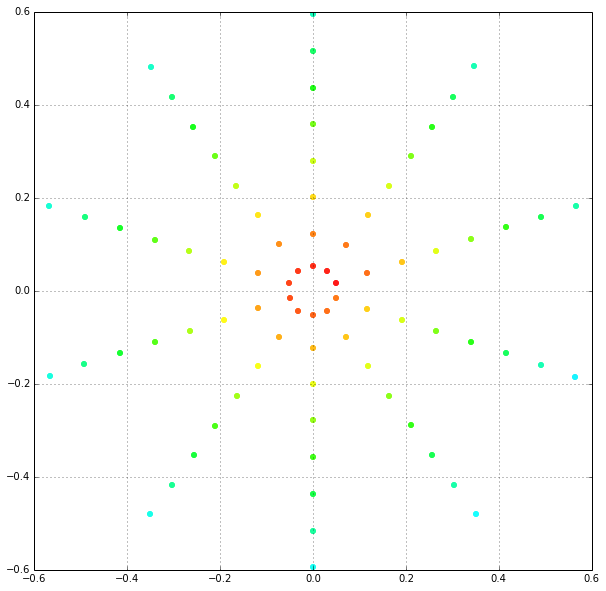

In [32]:
plt.figure(3, figsize=(10,10))
for az in xrange(n_azim_slices):
    for ri in xrange(n_rings):
        plt.plot(z_cl[az,ri], beta_z*dp_cl[az,ri], 'o', mec='None', #color=colorprog(j, n_rings))
                 color=colorprog(az+ri*n_rings, int(n_rings*n_azim_slices*1.6)))
plt.grid('on')
plt.show()

### Check cython vs. python results

In [16]:
i=29
j=24

print x_cl[i,j]
print y_cl[i,j]
print z_cl[i,j]
print dp_cl[i,j]
print n_cl[i,j]

0.000168238901025
0.000190986592416
0.395625460747
-0.00034110716228
432


In [17]:
print mean_x_cell[i,j]
print mean_y_cell[i,j]
print mean_z_cell[i,j]
print mean_dp_cell[i,j]
print n_particles_cell[i,j]

0.000168238901025
0.000190986592416
0.395625460747
-0.00034110716228
432.0


In [37]:
bunch.beta_z

AttributeError: 'Particles' object has no attribute 'beta_z'